In [ ]:
# Install necessary libraries
!pip install nltk gensim tensorflow

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 5.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.7/26.7 MB 17.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 40.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.6/38.6 MB 11.2 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
  Attempting uninstall: scipy
    Found existing installation: scipy 1.15.3
    Uninstalling scipy-1.15.3:
      Successfully uninstalled scipy-1.15.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tsfresh 0.21.0 requires scipy>=1.14.0; python_version >= "3.10", but you have scipy 1.13.1 which is incompatible.
thinc 8.3.6 req

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import (
    LSTM, GRU, Bidirectional, Dense, Embedding, Dropout,
    GlobalMaxPooling1D, Input, Concatenate, BatchNormalization
)
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Load the actual dataset
df = pd.read_csv('news.csv')

# Check the dataset structure
print(f"Dataset shape: {df.shape}")
print(f"Columns: {df.columns.tolist()}")
print(f"Label distribution:\n{df['label'].value_counts()}")

Dataset shape: (6335, 4)
Columns: ['Unnamed: 0', 'title', 'text', 'label']
Label distribution:
label
REAL    3171
FAKE    3164
Name: count, dtype: int64


In [ ]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Download required NLTK data
try:
    nltk.data.find('tokenizers/punkt')
    nltk.data.find('corpora/stopwords')
    nltk.data.find('corpora/wordnet')
except LookupError:
    nltk.download('punkt')
    nltk.download('stopwords')
    nltk.download('wordnet')
    nltk.download('averaged_perceptron_tagger')

def preprocess_text(text):
    """
    Comprehensive text preprocessing function
    """
    if not isinstance(text, str):
        return ""

    # Convert to lowercase
    text = text.lower()

    # Remove special characters and digits
    text = re.sub(r'[^a-zA-Z\s]', '', text)

    # Remove extra whitespaces
    text = re.sub(r'\s+', ' ', text).strip()

    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = text.split()
    filtered_tokens = [word for word in tokens if word not in stop_words and len(word) > 2]

    # Lemmatization
    lemmatizer = WordNetLemmatizer()
    lemmatized_tokens = [lemmatizer.lemmatize(word) for word in filtered_tokens]

    return ' '.join(lemmatized_tokens)

# Apply preprocessing
print("Preprocessing text data...")
df['processed_title'] = df['title'].apply(preprocess_text)
df['processed_text'] = df['text'].apply(preprocess_text)

# Remove empty processed texts
df = df[(df['processed_title'].str.len() > 0) & (df['processed_text'].str.len() > 0)].reset_index(drop=True)
print(f"Dataset shape after preprocessing: {df.shape}")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


Preprocessing text data...
Dataset shape after preprocessing: (6295, 6)


In [ ]:
# Encode labels
label_encoder = LabelEncoder()
df['label_encoded'] = label_encoder.fit_transform(df['label'])
num_classes = len(label_encoder.classes_)

print(f"Number of classes: {num_classes}")
print(f"Classes: {label_encoder.classes_}")

Number of classes: 2
Classes: ['FAKE' 'REAL']


In [ ]:
print("Creating TF-IDF vectors...")

# TF-IDF for titles
tfidf_title_vectorizer = TfidfVectorizer(
    max_features=5000,
    ngram_range=(1, 2),
    min_df=2,
    max_df=0.95
)

# TF-IDF for descriptions (text)
tfidf_desc_vectorizer = TfidfVectorizer(
    max_features=5000,
    ngram_range=(1, 2),
    min_df=2,
    max_df=0.95
)

# Fit and transform on training data first (we'll split later)
# For now, fit on full dataset and then split
tfidf_title = tfidf_title_vectorizer.fit_transform(df['processed_title'])
tfidf_desc = tfidf_desc_vectorizer.fit_transform(df['processed_text'])

# Create DataFrame as specified in requirements
df_tfidf = pd.DataFrame({
    'tfidf_title': tfidf_title.toarray().tolist(),
    'tfidf_desc': tfidf_desc.toarray().tolist()
})

print(f"TF-IDF DataFrame shape: {df_tfidf.shape}")
print("TF-IDF DataFrame created successfully!")

Creating TF-IDF vectors...
TF-IDF DataFrame shape: (6295, 2)
TF-IDF DataFrame created successfully!


In [ ]:
# Parameters for tokenization and padding
MAX_WORDS = 10000
MAX_LEN_TITLE = 50
MAX_LEN_TEXT = 200

# Split data first
X_title = df['processed_title']
X_text = df['processed_text']
y = df['label_encoded']

# Train-test split
X_title_train, X_title_test, X_text_train, X_text_test, y_train, y_test = train_test_split(
    X_title, X_text, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training set size: {len(X_title_train)}")
print(f"Test set size: {len(X_title_test)}")

# Tokenization - Fit on training data only
print("Tokenizing text data...")

# Tokenizer for titles
tokenizer_title = Tokenizer(num_words=MAX_WORDS, oov_token="<OOV>")
tokenizer_title.fit_on_texts(X_title_train)  # Fit on training data only

# Tokenizer for text
tokenizer_text = Tokenizer(num_words=MAX_WORDS, oov_token="<OOV>")
tokenizer_text.fit_on_texts(X_text_train)  # Fit on training data only

# Convert to sequences
X_title_train_seq = tokenizer_title.texts_to_sequences(X_title_train)
X_title_test_seq = tokenizer_title.texts_to_sequences(X_title_test)

X_text_train_seq = tokenizer_text.texts_to_sequences(X_text_train)
X_text_test_seq = tokenizer_text.texts_to_sequences(X_text_test)

# Padding - using parameters determined from training set
print("Applying padding...")

X_title_train_padded = pad_sequences(X_title_train_seq, maxlen=MAX_LEN_TITLE, padding='post', truncating='post')
X_title_test_padded = pad_sequences(X_title_test_seq, maxlen=MAX_LEN_TITLE, padding='post', truncating='post')

X_text_train_padded = pad_sequences(X_text_train_seq, maxlen=MAX_LEN_TEXT, padding='post', truncating='post')
X_text_test_padded = pad_sequences(X_text_test_seq, maxlen=MAX_LEN_TEXT, padding='post', truncating='post')

# Convert labels to categorical
y_train_cat = to_categorical(y_train, num_classes=num_classes)
y_test_cat = to_categorical(y_test, num_classes=num_classes)

print(f"Title sequences shape: {X_title_train_padded.shape}")
print(f"Text sequences shape: {X_text_train_padded.shape}")
print(f"Labels shape: {y_train_cat.shape}")

Training set size: 5036
Test set size: 1259
Tokenizing text data...
Applying padding...
Title sequences shape: (5036, 50)
Text sequences shape: (5036, 200)
Labels shape: (5036, 2)


In [ ]:
def create_lstm_model(vocab_size, embedding_dim=128, num_classes=num_classes):
    """
    Create LSTM model for text classification
    """
    # Input layers
    title_input = Input(shape=(MAX_LEN_TITLE,), name='title_input')
    text_input = Input(shape=(MAX_LEN_TEXT,), name='text_input')

    # Embedding layers
    title_embedding = Embedding(vocab_size, embedding_dim, input_length=MAX_LEN_TITLE)(title_input)
    text_embedding = Embedding(vocab_size, embedding_dim, input_length=MAX_LEN_TEXT)(text_input)

    # LSTM layers
    title_lstm = LSTM(64, dropout=0.3, recurrent_dropout=0.3)(title_embedding)
    text_lstm = LSTM(128, dropout=0.3, recurrent_dropout=0.3)(text_embedding)

    # Concatenate features
    merged = Concatenate()([title_lstm, text_lstm])

    # Dense layers
    dense1 = Dense(128, activation='relu')(merged)
    dropout1 = Dropout(0.5)(dense1)
    dense2 = Dense(64, activation='relu')(dropout1)
    dropout2 = Dropout(0.3)(dense2)

    # Output layer
    output = Dense(num_classes, activation='softmax', name='output')(dropout2)

    # Create model
    model = Model(inputs=[title_input, text_input], outputs=output)

    return model

# Create LSTM model
print("Creating LSTM model...")
lstm_model = create_lstm_model(MAX_WORDS)
lstm_model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print("LSTM Model Architecture:")
lstm_model.summary()

Creating LSTM model...
LSTM Model Architecture:


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ title_input         │ (None, 50)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ text_input          │ (None, 200)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 50, 128)   │  1,280,000 │ title_input[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_1         │ (None, 200, 128)  │  1,280,000 │ text_input[0][0]  │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ (None, 64)        │     49,408 │ embedding[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_1 (LSTM)       │ (None, 128)       │    131,584 │ embedding_1[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 192)       │          0 │ lstm[0][0],       │
│ (Concatenate)       │                   │            │ lstm_1[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 128)       │     24,704 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 128)       │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 64)        │      8,256 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 64)        │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output (Dense)      │ (None, 2)         │        130 │ dropout_1[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,774,082 (10.58 MB)

 Trainable params: 2,774,082 (10.58 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
def create_gru_model(vocab_size, embedding_dim=128, num_classes=num_classes):
    """
    Create GRU model for text classification
    """
    # Input layers
    title_input = Input(shape=(MAX_LEN_TITLE,), name='title_input')
    text_input = Input(shape=(MAX_LEN_TEXT,), name='text_input')

    # Embedding layers
    title_embedding = Embedding(vocab_size, embedding_dim, input_length=MAX_LEN_TITLE)(title_input)
    text_embedding = Embedding(vocab_size, embedding_dim, input_length=MAX_LEN_TEXT)(text_input)

    # GRU layers
    title_gru = GRU(64, dropout=0.3, recurrent_dropout=0.3)(title_embedding)
    text_gru = GRU(128, dropout=0.3, recurrent_dropout=0.3)(text_embedding)

    # Concatenate features
    merged = Concatenate()([title_gru, text_gru])

    # Dense layers
    dense1 = Dense(128, activation='relu')(merged)
    dropout1 = Dropout(0.5)(dense1)
    dense2 = Dense(64, activation='relu')(dropout1)
    dropout2 = Dropout(0.3)(dense2)

    # Output layer
    output = Dense(num_classes, activation='softmax', name='output')(dropout2)

    # Create model
    model = Model(inputs=[title_input, text_input], outputs=output)

    return model

# Create GRU model
print("Creating GRU model...")
gru_model = create_gru_model(MAX_WORDS)
gru_model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print("GRU Model Architecture:")
gru_model.summary()

Creating GRU model...
GRU Model Architecture:


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ title_input         │ (None, 50)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ text_input          │ (None, 200)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_2         │ (None, 50, 128)   │  1,280,000 │ title_input[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_3         │ (None, 200, 128)  │  1,280,000 │ text_input[0][0]  │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru (GRU)           │ (None, 64)        │     37,248 │ embedding_2[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_1 (GRU)         │ (None, 128)       │     99,072 │ embedding_3[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 192)       │          0 │ gru[0][0],        │
│ (Concatenate)       │                   │            │ gru_1[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 128)       │     24,704 │ concatenate_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 128)       │          0 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 64)        │      8,256 │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 64)        │          0 │ dense_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output (Dense)      │ (None, 2)         │        130 │ dropout_3[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,729,410 (10.41 MB)

 Trainable params: 2,729,410 (10.41 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
def create_bigru_model(vocab_size, embedding_dim=128, num_classes=num_classes):
    """
    Create Bidirectional GRU model for text classification
    """
    # Input layers
    title_input = Input(shape=(MAX_LEN_TITLE,), name='title_input')
    text_input = Input(shape=(MAX_LEN_TEXT,), name='text_input')

    # Embedding layers
    title_embedding = Embedding(vocab_size, embedding_dim, input_length=MAX_LEN_TITLE)(title_input)
    text_embedding = Embedding(vocab_size, embedding_dim, input_length=MAX_LEN_TEXT)(text_input)

    # Bidirectional GRU layers
    title_bigru = Bidirectional(GRU(64, dropout=0.3, recurrent_dropout=0.3))(title_embedding)
    text_bigru = Bidirectional(GRU(128, dropout=0.3, recurrent_dropout=0.3))(text_embedding)

    # Concatenate features
    merged = Concatenate()([title_bigru, text_bigru])

    # Dense layers with batch normalization
    dense1 = Dense(128, activation='relu')(merged)
    batch_norm1 = BatchNormalization()(dense1)
    dropout1 = Dropout(0.5)(batch_norm1)

    dense2 = Dense(64, activation='relu')(dropout1)
    batch_norm2 = BatchNormalization()(dense2)
    dropout2 = Dropout(0.3)(batch_norm2)

    # Output layer
    output = Dense(num_classes, activation='softmax', name='output')(dropout2)

    # Create model
    model = Model(inputs=[title_input, text_input], outputs=output)

    return model

# Create BiGRU model
print("Creating BiGRU model...")
bigru_model = create_bigru_model(MAX_WORDS)
bigru_model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print("BiGRU Model Architecture:")
bigru_model.summary()

Creating BiGRU model...
BiGRU Model Architecture:


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ title_input         │ (None, 50)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ text_input          │ (None, 200)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_4         │ (None, 50, 128)   │  1,280,000 │ title_input[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_5         │ (None, 200, 128)  │  1,280,000 │ text_input[0][0]  │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional       │ (None, 128)       │     74,496 │ embedding_4[0][0] │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_1     │ (None, 256)       │    198,144 │ embedding_5[0][0] │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_2       │ (None, 384)       │          0 │ bidirectional[0]… │
│ (Concatenate)       │                   │            │ bidirectional_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 128)       │     49,280 │ concatenate_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 128)       │        512 │ dense_4[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 128)       │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 64)        │      8,256 │ dropout_4[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64)        │        256 │ dense_5[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_5 (Dropout) │ (None, 64)        │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output (Dense)      │ (None, 2)         │        130 │ dropout_5[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,891,074 (11.03 MB)

 Trainable params: 2,890,690 (11.03 MB)

 Non-trainable params: 384 (1.50 KB)

In [ ]:
# Define callbacks
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=3,
    min_lr=0.0001,
    verbose=1
)

callbacks = [early_stopping, reduce_lr]

# Training parameters
EPOCHS = 20
BATCH_SIZE = 32

# Prepare training data
train_data = [X_title_train_padded, X_text_train_padded]
val_data = [X_title_test_padded, X_text_test_padded]

print("Training models...")

# Train LSTM model
print("\n" + "="*50)
print("Training LSTM Model")
print("="*50)

history_lstm = lstm_model.fit(
    train_data, y_train_cat,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(val_data, y_test_cat),
    callbacks=callbacks,
    verbose=1
)

# Train GRU model
print("\n" + "="*50)
print("Training GRU Model")
print("="*50)

history_gru = gru_model.fit(
    train_data, y_train_cat,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(val_data, y_test_cat),
    callbacks=callbacks,
    verbose=1
)

# Train BiGRU model
print("\n" + "="*50)
print("Training BiGRU Model")
print("="*50)

history_bigru = bigru_model.fit(
    train_data, y_train_cat,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(val_data, y_test_cat),
    callbacks=callbacks,
    verbose=1
)

Training models...

Training LSTM Model
Epoch 1/20
158/158 ━━━━━━━━━━━━━━━━━━━━ 98s 558ms/step - accuracy: 0.6293 - loss: 0.6386 - val_accuracy: 0.7792 - val_loss: 0.4919 - learning_rate: 0.0010
Epoch 2/20
158/158 ━━━━━━━━━━━━━━━━━━━━ 99s 628ms/step - accuracy: 0.7998 - loss: 0.4758 - val_accuracy: 0.8102 - val_loss: 0.4484 - learning_rate: 0.0010
Epoch 3/20
158/158 ━━━━━━━━━━━━━━━━━━━━ 133s 572ms/step - accuracy: 0.8242 - loss: 0.4176 - val_accuracy: 0.8149 - val_loss: 0.4381 - learning_rate: 0.0010
Epoch 4/20
158/158 ━━━━━━━━━━━━━━━━━━━━ 89s 561ms/step - accuracy: 0.8657 - loss: 0.3294 - val_accuracy: 0.7697 - val_loss: 0.5394 - learning_rate: 0.0010
Epoch 5/20
158/158 ━━━━━━━━━━━━━━━━━━━━ 89s 563ms/step - accuracy: 0.8904 - loss: 0.2469 - val_accuracy: 0.7538 - val_loss: 0.6517 - learning_rate: 0.0010
Epoch 6/20
158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 524ms/step - accuracy: 0.9072 - loss: 0.2089
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
158/158 ━━━━━━━━━━━

In [ ]:
print("\n" + "="*60)
print("MODEL EVALUATION")
print("="*60)

# Evaluate models
lstm_loss, lstm_accuracy = lstm_model.evaluate(val_data, y_test_cat, verbose=0)
gru_loss, gru_accuracy = gru_model.evaluate(val_data, y_test_cat, verbose=0)
bigru_loss, bigru_accuracy = bigru_model.evaluate(val_data, y_test_cat, verbose=0)

print(f"LSTM Model - Loss: {lstm_loss:.4f}, Accuracy: {lstm_accuracy:.4f}")
print(f"GRU Model - Loss: {gru_loss:.4f}, Accuracy: {gru_accuracy:.4f}")
print(f"BiGRU Model - Loss: {bigru_loss:.4f}, Accuracy: {bigru_accuracy:.4f}")

# Get predictions
lstm_pred = lstm_model.predict(val_data)
gru_pred = gru_model.predict(val_data)
bigru_pred = bigru_model.predict(val_data)

# Convert predictions to class labels
lstm_pred_classes = np.argmax(lstm_pred, axis=1)
gru_pred_classes = np.argmax(gru_pred, axis=1)
bigru_pred_classes = np.argmax(bigru_pred, axis=1)

y_test_classes = np.argmax(y_test_cat, axis=1)

# Classification reports
print("\n" + "="*50)
print("CLASSIFICATION REPORTS")
print("="*50)

print("\nLSTM Classification Report:")
print(classification_report(y_test_classes, lstm_pred_classes, target_names=label_encoder.classes_))

print("\nGRU Classification Report:")
print(classification_report(y_test_classes, gru_pred_classes, target_names=label_encoder.classes_))

print("\nBiGRU Classification Report:")
print(classification_report(y_test_classes, bigru_pred_classes, target_names=label_encoder.classes_))


MODEL EVALUATION
LSTM Model - Loss: 0.4381, Accuracy: 0.8149
GRU Model - Loss: 0.4741, Accuracy: 0.7712
BiGRU Model - Loss: 0.2556, Accuracy: 0.8983
40/40 ━━━━━━━━━━━━━━━━━━━━ 5s 106ms/step
40/40 ━━━━━━━━━━━━━━━━━━━━ 4s 81ms/step
40/40 ━━━━━━━━━━━━━━━━━━━━ 8s 170ms/step

CLASSIFICATION REPORTS

LSTM Classification Report:
              precision    recall  f1-score   support

        FAKE       0.76      0.91      0.83       625
        REAL       0.89      0.72      0.80       634

    accuracy                           0.81      1259
   macro avg       0.83      0.82      0.81      1259
weighted avg       0.83      0.81      0.81      1259


GRU Classification Report:
              precision    recall  f1-score   support

        FAKE       0.71      0.90      0.80       625
        REAL       0.87      0.64      0.74       634

    accuracy                           0.77      1259
   macro avg       0.79      0.77      0.77      1259
weighted avg       0.79      0.77      0.77     

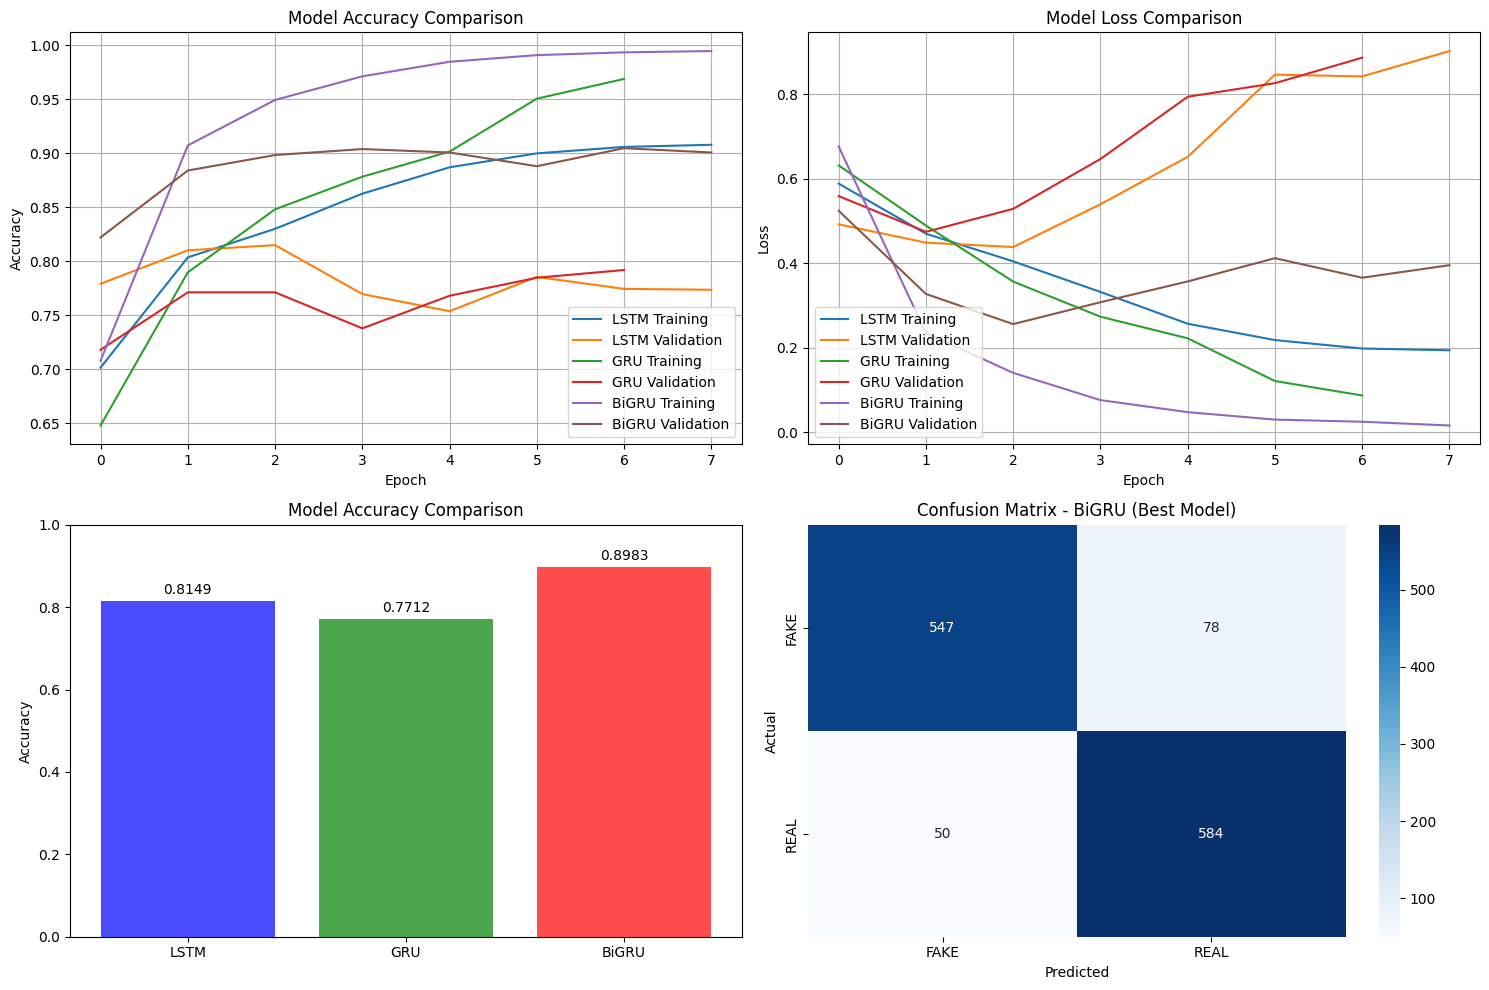

In [ ]:
def plot_training_history(histories, model_names):
    """
    Plot training history for multiple models
    """
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))

    # Plot accuracy
    for i, (history, name) in enumerate(zip(histories, model_names)):
        axes[0, 0].plot(history.history['accuracy'], label=f'{name} Training')
        axes[0, 0].plot(history.history['val_accuracy'], label=f'{name} Validation')

    axes[0, 0].set_title('Model Accuracy Comparison')
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Accuracy')
    axes[0, 0].legend()
    axes[0, 0].grid(True)

    # Plot loss
    for i, (history, name) in enumerate(zip(histories, model_names)):
        axes[0, 1].plot(history.history['loss'], label=f'{name} Training')
        axes[0, 1].plot(history.history['val_loss'], label=f'{name} Validation')

    axes[0, 1].set_title('Model Loss Comparison')
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('Loss')
    axes[0, 1].legend()
    axes[0, 1].grid(True)

    # Model comparison bar chart
    models = ['LSTM', 'GRU', 'BiGRU']
    accuracies = [lstm_accuracy, gru_accuracy, bigru_accuracy]

    axes[1, 0].bar(models, accuracies, color=['blue', 'green', 'red'], alpha=0.7)
    axes[1, 0].set_title('Model Accuracy Comparison')
    axes[1, 0].set_ylabel('Accuracy')
    axes[1, 0].set_ylim(0, 1)

    # Add accuracy values on bars
    for i, acc in enumerate(accuracies):
        axes[1, 0].text(i, acc + 0.01, f'{acc:.4f}', ha='center', va='bottom')

    # Confusion matrix for best model
    best_model_idx = np.argmax(accuracies)
    best_predictions = [lstm_pred_classes, gru_pred_classes, bigru_pred_classes][best_model_idx]

    cm = confusion_matrix(y_test_classes, best_predictions)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=label_encoder.classes_,
                yticklabels=label_encoder.classes_,
                ax=axes[1, 1])
    axes[1, 1].set_title(f'Confusion Matrix - {models[best_model_idx]} (Best Model)')
    axes[1, 1].set_xlabel('Predicted')
    axes[1, 1].set_ylabel('Actual')

    plt.tight_layout()
    plt.show()

# Plot training history
plot_training_history(
    [history_lstm, history_gru, history_bigru],
    ['LSTM', 'GRU', 'BiGRU']
)

In [ ]:
print("\n" + "="*60)
print("FINAL RESULTS SUMMARY")
print("="*60)

results_df = pd.DataFrame({
    'Model': ['LSTM', 'GRU', 'BiGRU'],
    'Accuracy': [lstm_accuracy, gru_accuracy, bigru_accuracy],
    'Loss': [lstm_loss, gru_loss, bigru_loss]
})

print(results_df.to_string(index=False))

best_model = results_df.loc[results_df['Accuracy'].idxmax(), 'Model']
best_accuracy = results_df['Accuracy'].max()

print(f"\nBest performing model: {best_model} with accuracy: {best_accuracy:.4f}")


FINAL RESULTS SUMMARY
Model  Accuracy     Loss
 LSTM  0.814932 0.438088
  GRU  0.771247 0.474108
BiGRU  0.898332 0.255550

Best performing model: BiGRU with accuracy: 0.8983


In [ ]:
print("\n" + "="*60)
print("SAMPLE PREDICTIONS")
print("="*60)

# Get sample predictions from the best model
sample_indices = np.random.choice(len(X_title_test_padded), 3, replace=False)

for i, idx in enumerate(sample_indices):
    print(f"\nSample {i+1}:")
    print(f"Title: {X_title_test.iloc[idx]}")
    print(f"Text: {X_text_test.iloc[idx][:100]}...")
    print(f"True Label: {label_encoder.classes_[y_test_classes[idx]]}")

    if best_model == 'LSTM':
        pred_class = lstm_pred_classes[idx]
    elif best_model == 'GRU':
        pred_class = gru_pred_classes[idx]
    else:  # BiGRU
        pred_class = bigru_pred_classes[idx]

    print(f"Predicted Label: {label_encoder.classes_[pred_class]}")
    print(f"Correct: {'✓' if y_test_classes[idx] == pred_class else '✗'}")

print("\n" + "="*60)
print("IMPLEMENTATION COMPLETED SUCCESSFULLY!")
print("="*60)

# Display TF-IDF DataFrame info
print(f"\nTF-IDF DataFrame shape: {df_tfidf.shape}")
print("TF-IDF DataFrame columns:", df_tfidf.columns.tolist())
print("Sample TF-IDF data:")
print(f"Title vector length: {len(df_tfidf['tfidf_title'].iloc[0])}")
print(f"Description vector length: {len(df_tfidf['tfidf_desc'].iloc[0])}")


SAMPLE PREDICTIONS

Sample 1:
Title: trumped deceiving american people new york time vow start reporting honestly
Text: nteb ad privacy policy trumped deceiving american people new york time vow start reporting honestly ...
True Label: FAKE
Predicted Label: FAKE
Correct: ✓

Sample 2:
Title: gop presidential hopeful serve ice cream cheese red meat iowan
Text: gop presidential hopeful serve ice cream cheese red meat iowan gop presidential hopeful spent saturd...
True Label: REAL
Predicted Label: REAL
Correct: ✓

Sample 3:
Title: hillary literally became definition pathological lying google yesterday
Text: antimedia happened google term pathological lying sunday evening would met none bright smiling face ...
True Label: FAKE
Predicted Label: FAKE
Correct: ✓

IMPLEMENTATION COMPLETED SUCCESSFULLY!

TF-IDF DataFrame shape: (6295, 2)
TF-IDF DataFrame columns: ['tfidf_title', 'tfidf_desc']
Sample TF-IDF data:
Title vector length: 5000
Description vector length: 5000
